# SOAI Lab: Smart Home Energy Consumption Prediction


# INSTALL DEPENDENCIES


## Part 0 : Import used libraries

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import holidays
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from prophet import Prophet
import lightgbm as lgb
from sklearn.discriminant_analysis import StandardScaler
from nbeats_pytorch.model import NBeatsNet
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

## Part 1 : Understand the data and Exploring it

### 1.1. Load the Training Data :
- The first step is to load the training data into the system. This is typically done using a data

In [172]:
# Load the training data
train_data = pd.read_csv('data/train_energy.csv')

### 1.2. Inspect the Training Data
- Inspect the training data to understand the distribution of the target variable and the features. This step is crucial

In [9]:
# Display the first few rows of the training data
print(train_data)

# Display information about the training data
print(train_data.info())

# Display summary statistics of the training data
print(train_data.describe())

# Check for missing values in the training data
print(train_data.isnull().sum())

                  DateTime  EnergyConsumption(kWh)
0      2015-11-01 00:00:00                      15
1      2015-11-01 01:00:00                      13
2      2015-11-01 02:00:00                      10
3      2015-11-01 03:00:00                       7
4      2015-11-01 04:00:00                       9
...                    ...                     ...
10244  2016-12-31 20:00:00                      37
10245  2016-12-31 21:00:00                      32
10246  2016-12-31 22:00:00                      33
10247  2016-12-31 23:00:00                      32
10248  2017-01-01 00:00:00                      27

[10249 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10249 entries, 0 to 10248
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DateTime                10249 non-null  object
 1   EnergyConsumption(kWh)  10249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 160.

### 1.3. Extracting Meaningful Informations
- Extracting temporal features form Datetime

In [173]:
# Convert DateTime to pandas datetime object
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])

In [5]:

# Extract features
train_data['hour'] = train_data['DateTime'].dt.hour
train_data['day_of_week'] = train_data['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
train_data['quarter'] = train_data['DateTime'].dt.quarter
train_data['is_weekend'] = train_data['day_of_week'] >= 5
train_data['month'] = train_data['DateTime'].dt.month
train_data['year'] = train_data['DateTime'].dt.year
train_data['day_of_year'] = train_data['DateTime'].dt.dayofyear
train_data['day_of_month'] = train_data['DateTime'].dt.day
train_data['week_of_year'] = train_data['DateTime'].dt.isocalendar().week
# Holiday feature
us_holidays = holidays.US()
train_data['is_holiday'] = train_data['DateTime'].isin(us_holidays).astype(int)

### 1.4. Visualising Trends
- Visualising trends is an important aspect of data analysis. It helps to identify patterns, relationships
and anomalies in the data. There are several types of visualisations that can be used to
visualise trends

#### 1.4.1. Hourly Trends

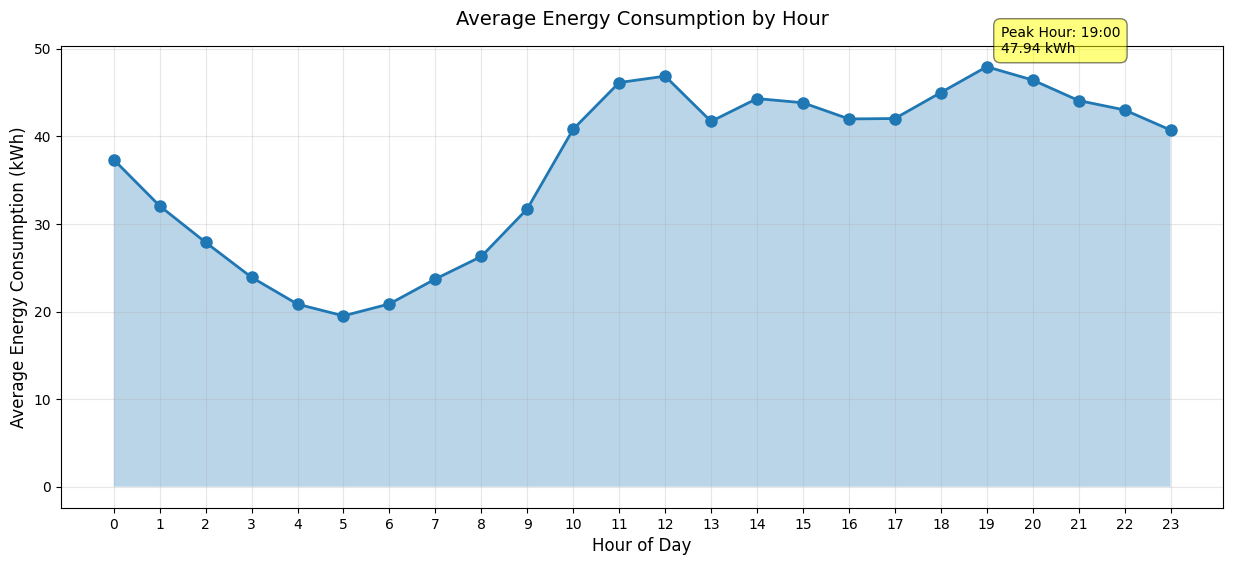

In [492]:
plt.figure(figsize=(15, 6))
hourly_avg = train_data.groupby('hour')['EnergyConsumption(kWh)'].mean()

plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=8)
plt.fill_between(hourly_avg.index, hourly_avg.values, alpha=0.3)
plt.title('Average Energy Consumption by Hour', fontsize=14, pad=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))

# Add peak hours annotation
peak_hour = hourly_avg.idxmax()
plt.annotate(f'Peak Hour: {peak_hour}:00\n{hourly_avg[peak_hour]:.2f} kWh', 
            xy=(peak_hour, hourly_avg[peak_hour]),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
plt.show()

#### 1.4.2. Daily Trends

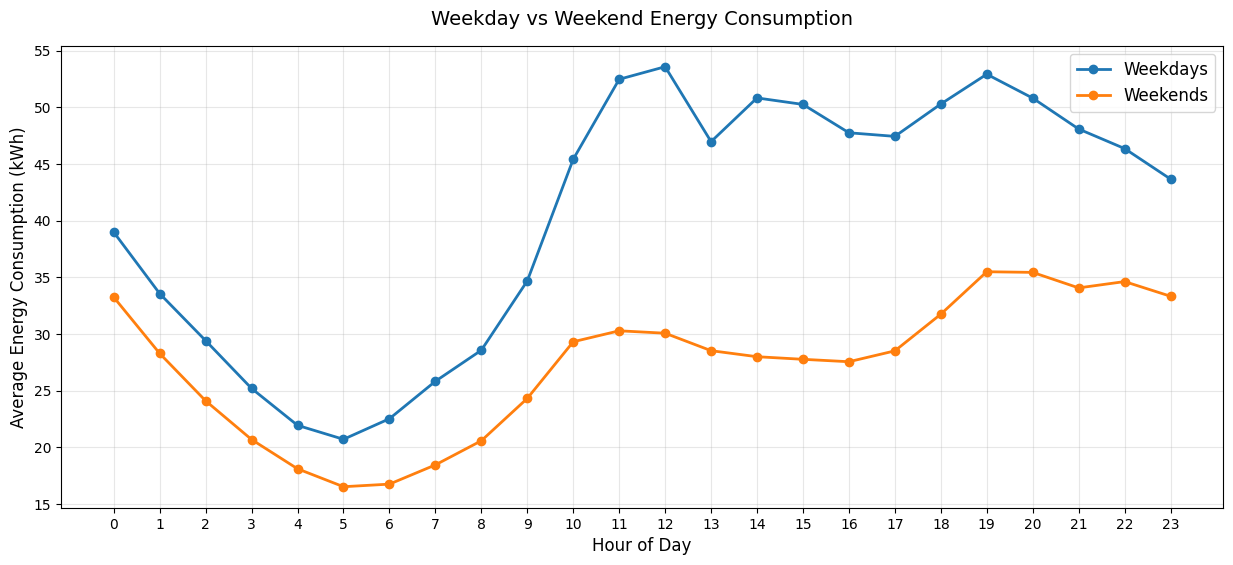

In [493]:
plt.figure(figsize=(15, 6))

# Calculate averages
weekday_hourly = train_data[~train_data['is_weekend']].groupby('hour')['EnergyConsumption(kWh)'].mean()
weekend_hourly = train_data[train_data['is_weekend']].groupby('hour')['EnergyConsumption(kWh)'].mean()

# Plot both lines
plt.plot(weekday_hourly.index, weekday_hourly.values, label='Weekdays', marker='o', linewidth=2)
plt.plot(weekend_hourly.index, weekend_hourly.values, label='Weekends', marker='o', linewidth=2)
plt.title('Weekday vs Weekend Energy Consumption', fontsize=14, pad=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(range(0, 24))
plt.show()

#### 1.4.3. Weekly Trends

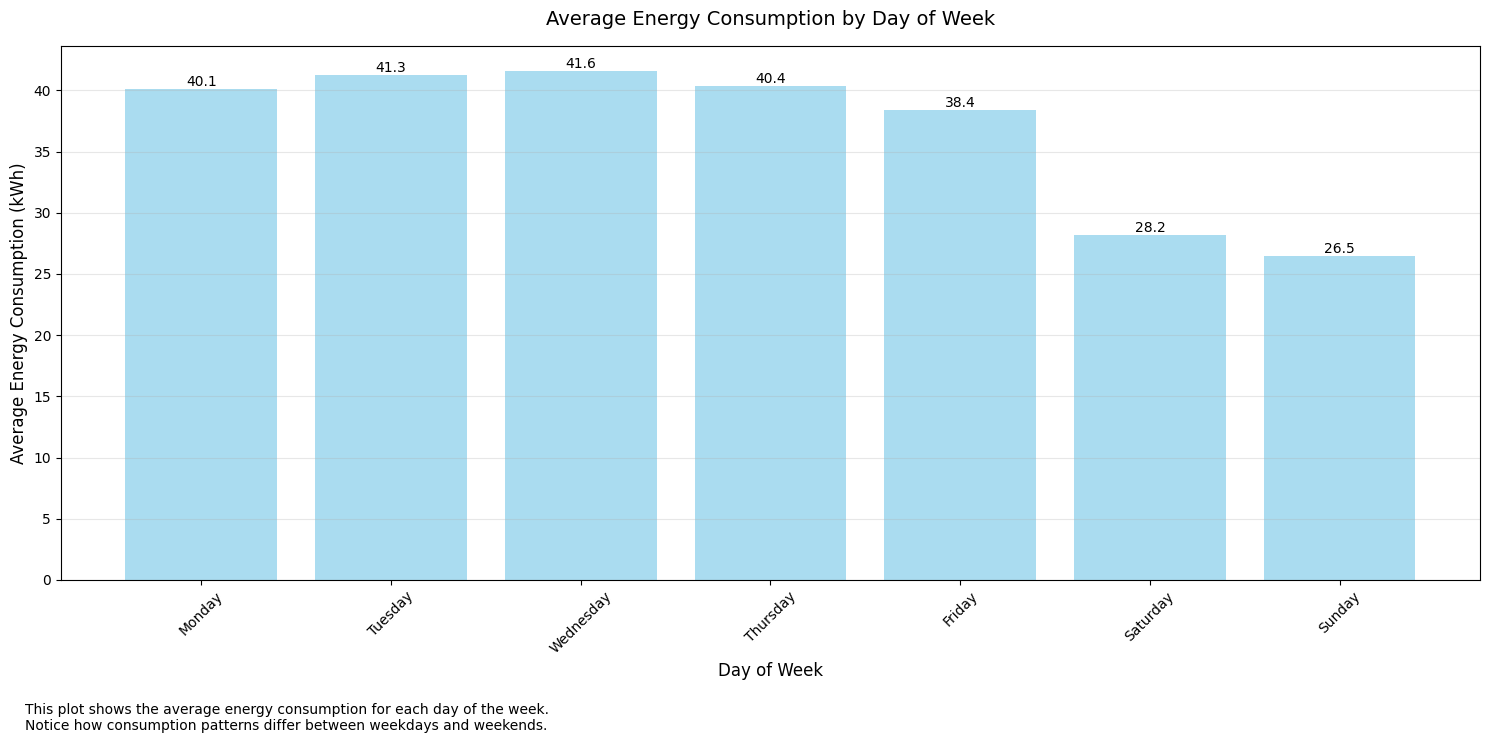

In [494]:
plt.figure(figsize=(15, 7))

daily_consumption = train_data.groupby('day_of_week')['EnergyConsumption(kWh)'].mean()

# Create bar plot
bars = plt.bar(daily_consumption.index, daily_consumption.values, 
               color='skyblue', alpha=0.7)

# Customize the plot
plt.title('Average Energy Consumption by Day of Week', fontsize=14, pad=15)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

# Customize x-axis labels
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(range(7), days, rotation=45)

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3)

# Add a brief explanation
plt.figtext(0.02, -0.05, 
            'This plot shows the average energy consumption for each day of the week.\nNotice how consumption patterns differ between weekdays and weekends.',
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

#### 1.4.4. Mounthly Trends

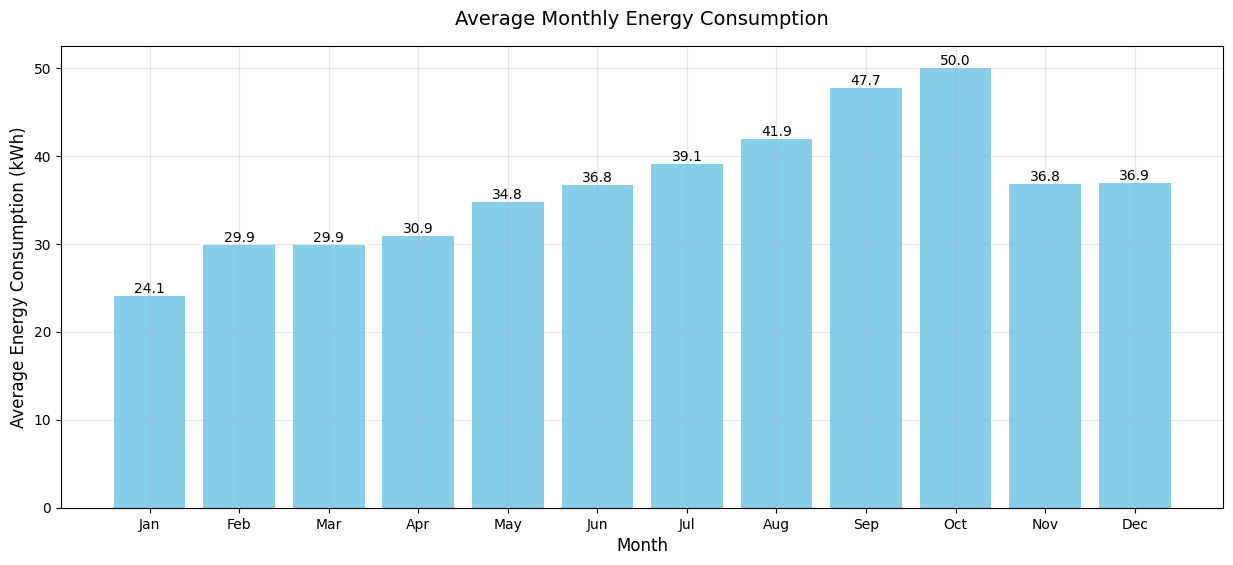

In [495]:
plt.figure(figsize=(15, 6))

# Calculate monthly averages
monthly_avg = train_data.groupby('month')['EnergyConsumption(kWh)'].mean()

# Create seasonal plot
bars = plt.bar(monthly_avg.index, monthly_avg.values, color='skyblue')
plt.title('Average Monthly Energy Consumption', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

#### 1.4.5. Time Series Plot

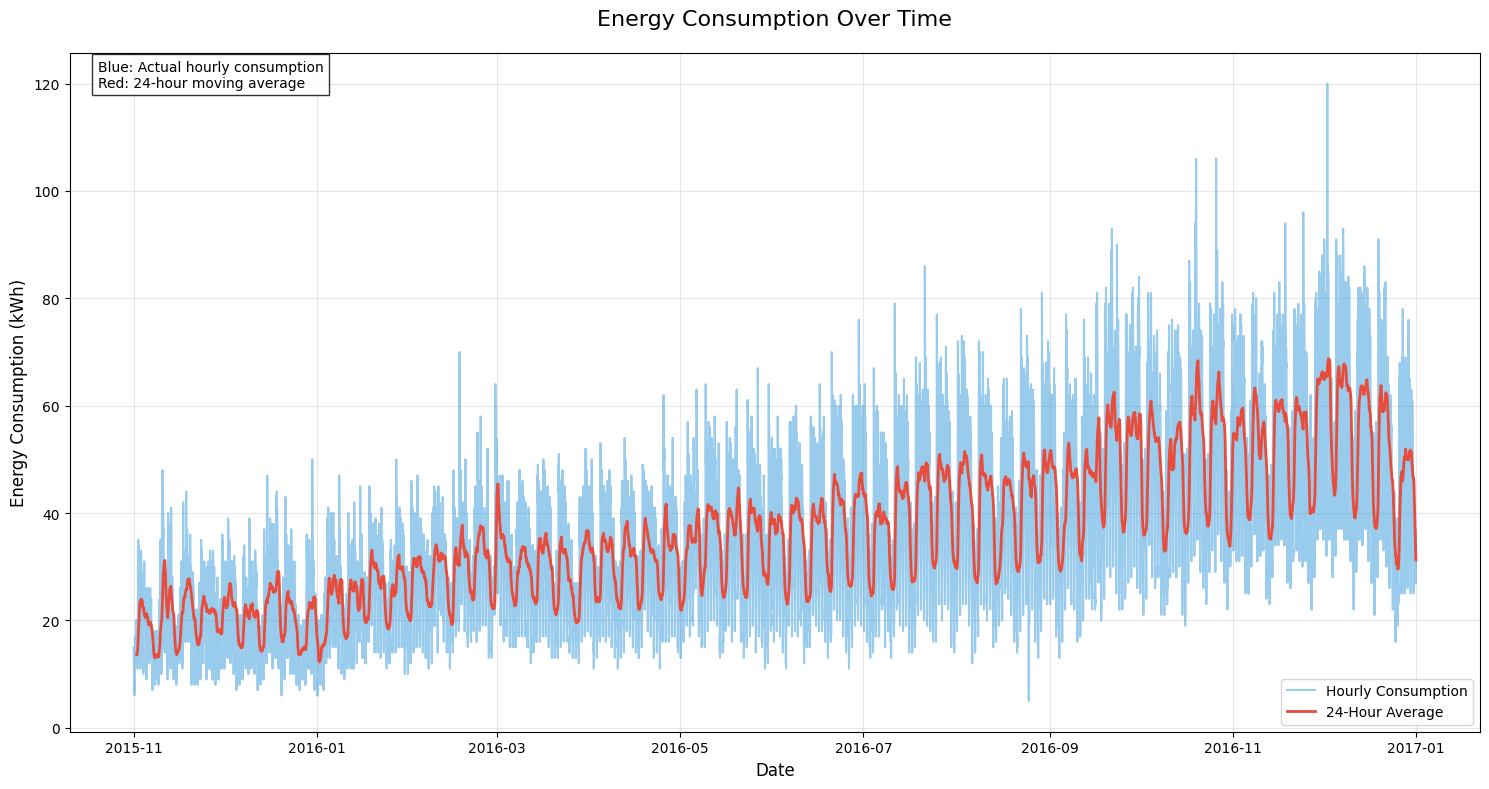

In [496]:
plt.figure(figsize=(15, 8))

plt.plot(train_data['DateTime'], train_data['EnergyConsumption(kWh)'],
         color='#3498db', alpha=0.5, label='Hourly Consumption')

# Add rolling average
window_size = 24  # 24 hours
rolling_avg = train_data['EnergyConsumption(kWh)'].rolling(window=window_size).mean()
plt.plot(train_data['DateTime'], rolling_avg,
         color='#e74c3c', linewidth=2, label='24-Hour Average')

# Customize plot
plt.title('Energy Consumption Over Time', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Add annotations
plt.annotate('Blue: Actual hourly consumption\nRed: 24-hour moving average',
            xy=(0.02, 0.95), xycoords='axes fraction',
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### 1.5. Correlation with Target Variable
The correlation between the target variable and the feature variables is an essential aspect of feature selection.
- **Positive Correlation**: If the correlation between the target variable and a feature variable is positive,
- **Negative Correlation**: If the correlation between the target variable and a feature variable is negative,
- **No Correlation**: If the correlation between the target variable and a feature variable is zero.

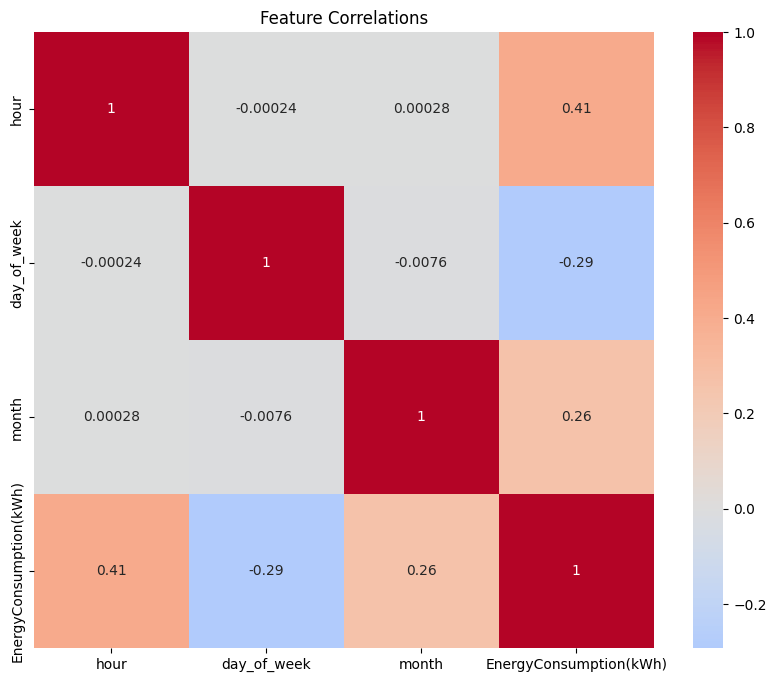

In [499]:
# Cell 10: Correlation Analysis
# Calculate correlations
correlation_matrix = train_data[['hour', 'day_of_week', 'month', 'EnergyConsumption(kWh)']].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.show()


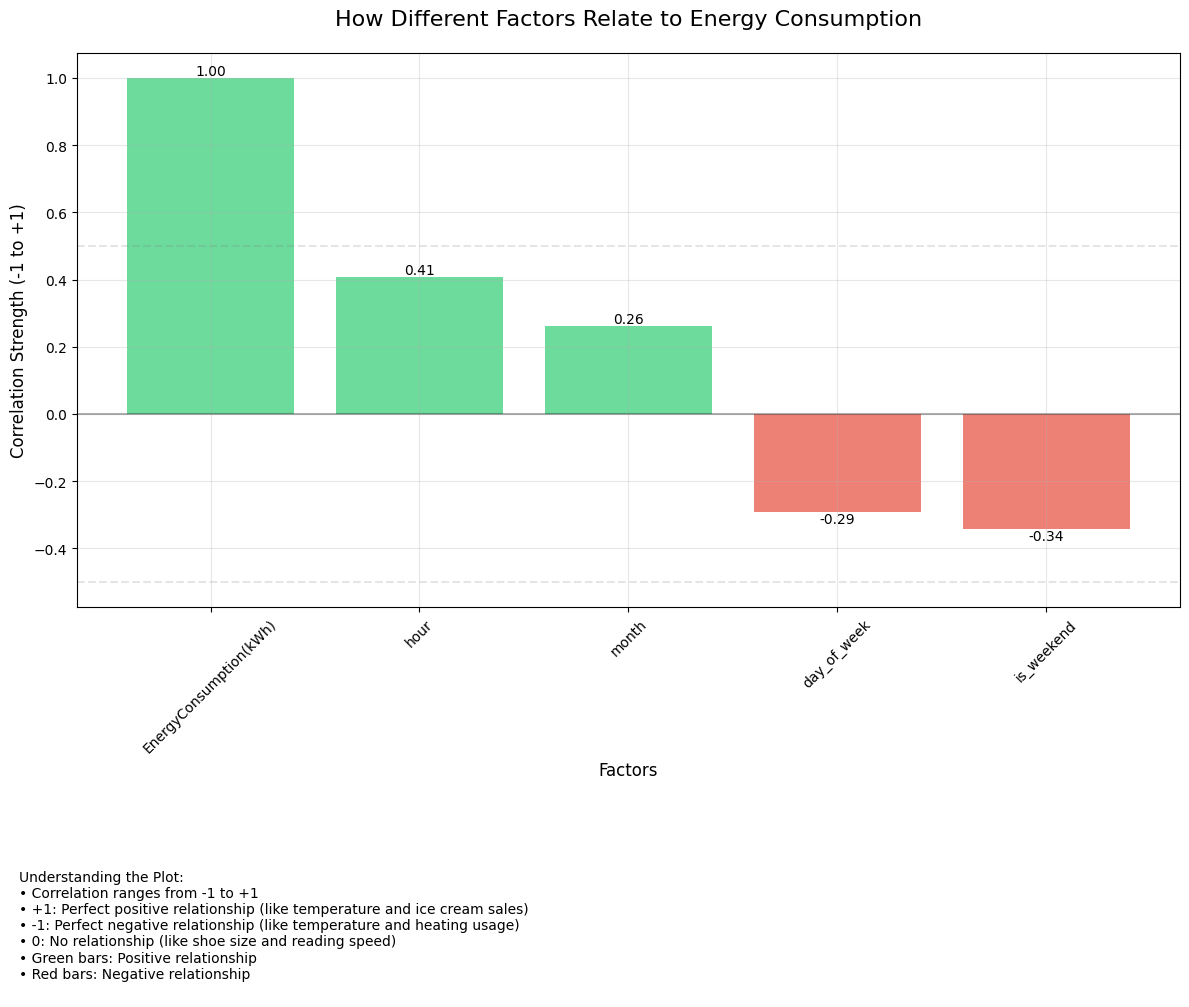

In [500]:
# Create figure
plt.figure(figsize=(12, 8))

# Calculate correlations with target
features = ['hour', 'day_of_week', 'month', 'is_weekend', 'EnergyConsumption(kWh)']
correlation_matrix = train_data[features].corr()['EnergyConsumption(kWh)'].sort_values(ascending=False)

# Create bar plot
colors = ['#2ecc71' if x >= 0 else '#e74c3c' for x in correlation_matrix]
bars = plt.bar(range(len(correlation_matrix)), 
               correlation_matrix,
               color=colors,
               alpha=0.7)

# Customize appearance
plt.title('How Different Factors Relate to Energy Consumption', fontsize=16, pad=20)
plt.xlabel('Factors', fontsize=12)
plt.ylabel('Correlation Strength (-1 to +1)', fontsize=12)

# Add feature labels
plt.xticks(range(len(correlation_matrix)), 
           correlation_matrix.index,
           rotation=45)

# Add correlation values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height,
             f'{height:.2f}',
             ha='center', 
             va='bottom' if height >= 0 else 'top')

# Add reference lines
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.2)
plt.axhline(y=-0.5, color='gray', linestyle='--', alpha=0.2)

# Add explanation box
explanation_text = '''
Understanding the Plot:
• Correlation ranges from -1 to +1
• +1: Perfect positive relationship (like temperature and ice cream sales)
• -1: Perfect negative relationship (like temperature and heating usage)
• 0: No relationship (like shoe size and reading speed)
• Green bars: Positive relationship
• Red bars: Negative relationship
'''

plt.figtext(0.02, -0.25, explanation_text, fontsize=10, ha='left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [501]:
# Print numerical interpretation
print("\nRelationship Strength Summary:")
for feature, corr in correlation_matrix.items():
    strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
    direction = "increases" if corr > 0 else "decreases"
    print(f"• When {feature} goes up, energy consumption tends to {direction} ({strength} relationship: {corr:.2f})")


Relationship Strength Summary:
• When EnergyConsumption(kWh) goes up, energy consumption tends to increases (strong relationship: 1.00)
• When hour goes up, energy consumption tends to increases (moderate relationship: 0.41)
• When month goes up, energy consumption tends to increases (weak relationship: 0.26)
• When day_of_week goes up, energy consumption tends to decreases (weak relationship: -0.29)
• When is_weekend goes up, energy consumption tends to decreases (moderate relationship: -0.34)


### 1.6. Time Series Decomposition
- Time series decomposition is a technique used to break down a time series into its underlying components. This can
include trend, seasonality, and residuals. The goal of decomposition is to identify the underlying patterns and
trends in the data, which can be useful for forecasting and other applications.

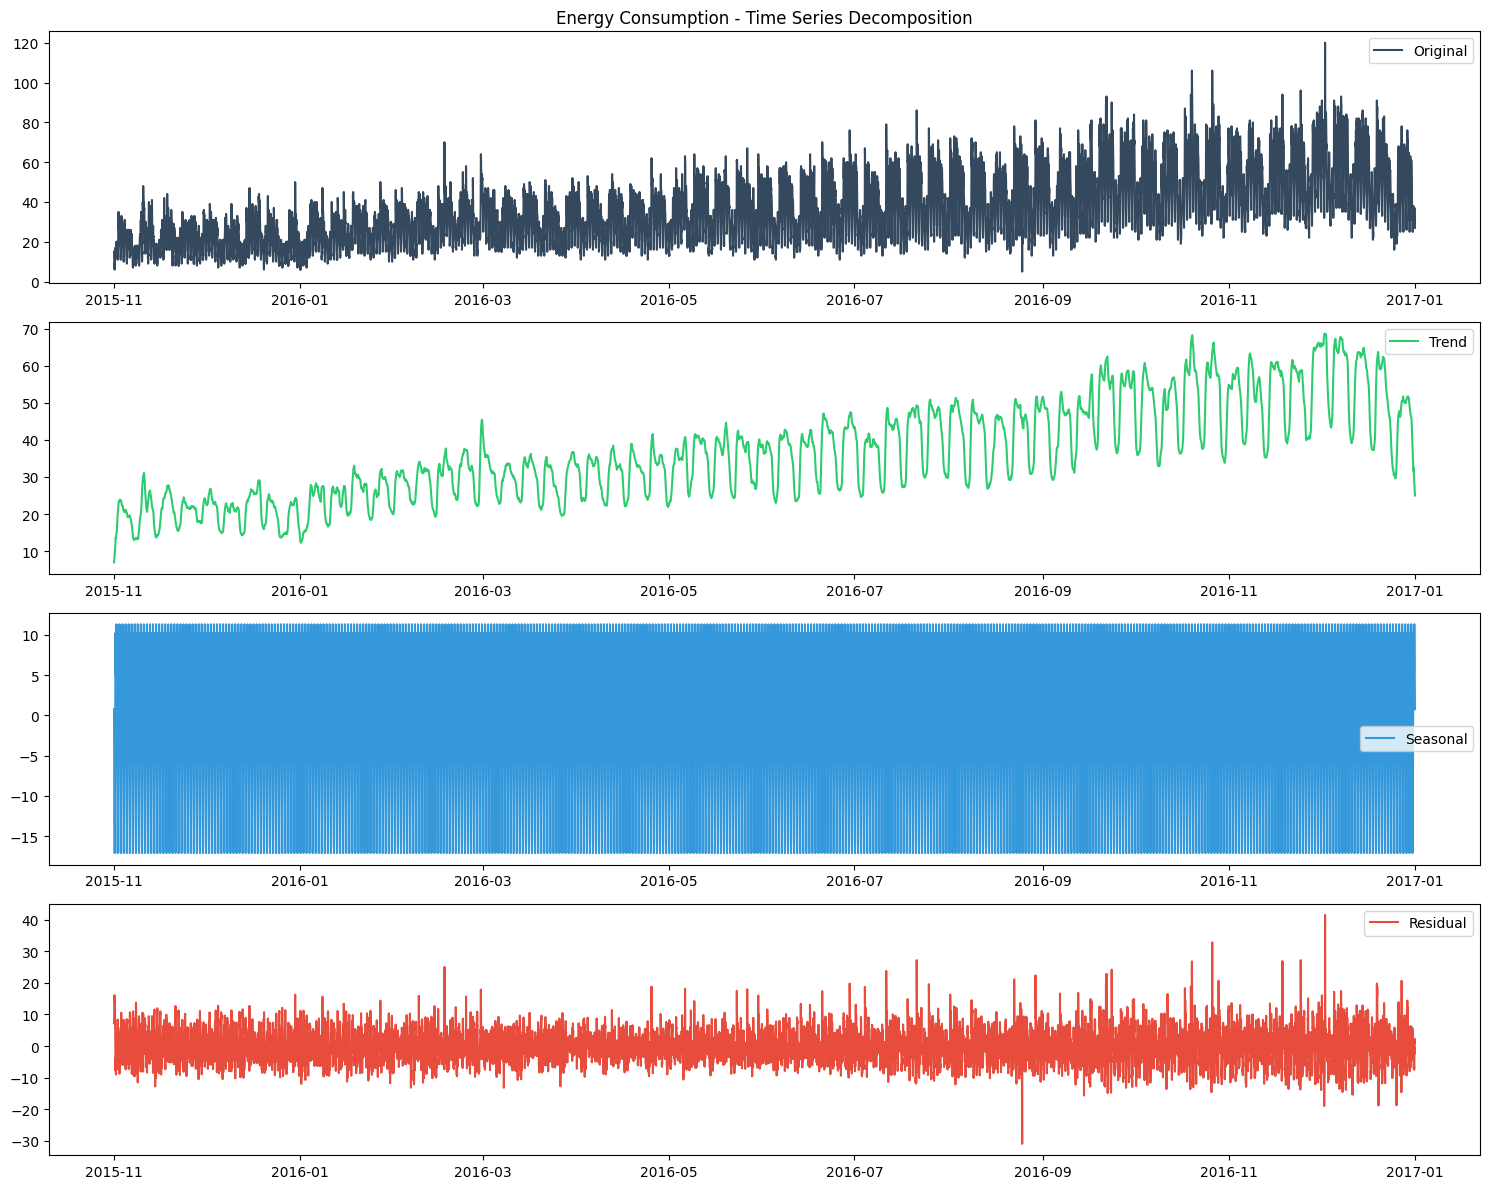

In [502]:
# Prepare time series data
ts_data = train_data.set_index('DateTime')['EnergyConsumption(kWh)']

# Decompose series
decomposition = seasonal_decompose(ts_data, 
                                 period=24,  # Daily seasonality
                                 extrapolate_trend='freq')

# Visualize components
plt.figure(figsize=(15, 12))

# Plot components
components = ['Original', 'Trend', 'Seasonal', 'Residual']
data = [ts_data, decomposition.trend, 
        decomposition.seasonal, decomposition.resid]
colors = ['#34495e', '#2ecc71', '#3498db', '#e74c3c']

for idx, (title, data, color) in enumerate(zip(components, data, colors), 1):
    plt.subplot(4, 1, idx)
    plt.plot(data, color=color, label=title)
    plt.legend()
    if idx == 1:
        plt.title('Energy Consumption - Time Series Decomposition')

plt.tight_layout()
plt.show()

## Step 2 : Data Splitting

### 2.1. Sort and Split into train and validation

In [174]:
# Sort by DateTime
train_data = train_data.sort_values(by='DateTime')

# Define split index
split_index = int(0.8 * len(train_data))

# Split into train and validation
train_df = train_data[:split_index]
val_df = train_data[split_index:]

### 2.2. Visualize Split data

/home/adel_hb/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


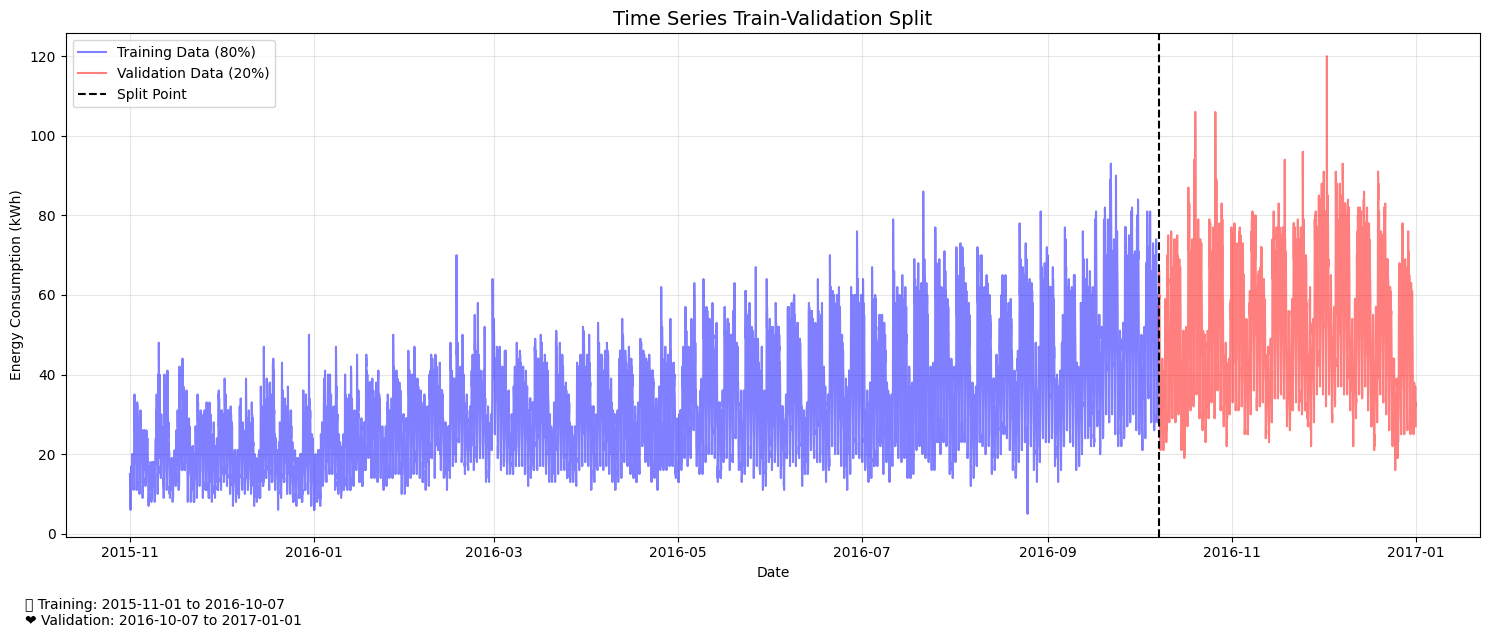

In [147]:
# Cell 2: Visualize Split
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(train_df['DateTime'], train_df['EnergyConsumption(kWh)'],
         color='blue', alpha=0.5, label='Training Data (80%)')

# Plot validation data
plt.plot(val_df['DateTime'], val_df['EnergyConsumption(kWh)'],
         color='red', alpha=0.5, label='Validation Data (20%)')

# Add split line
split_date = train_df['DateTime'].max()
plt.axvline(x=split_date, color='black', linestyle='--', label='Split Point')

# Customize plot
plt.title('Time Series Train-Validation Split', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add explanation
plt.figtext(0.02, -0.05, 
            f'🟢 Training: {train_df["DateTime"].min().date()} to {train_df["DateTime"].max().date()}\n' +
            f'❤️ Validation: {val_df["DateTime"].min().date()} to {val_df["DateTime"].max().date()}',
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

### 2.3. Print Split Informations

In [148]:

# Cell 3: Print Split Information
print("\nTime Series Split Summary:")
print(f"Total samples: {len(train_data)}")
print(f"Training samples: {len(train_df)} ({len(train_df)/len(train_data)*100:.1f}%)")
print(f"Validation samples: {len(val_df)} ({len(val_df)/len(train_data)*100:.1f}%)")
print(f"\nTraining period: {train_df['DateTime'].min()} to {train_df['DateTime'].max()}")
print(f"Validation period: {val_df['DateTime'].min()} to {val_df['DateTime'].max()}")

print(train_df.head())
print(val_df.head())



Time Series Split Summary:
Total samples: 10249
Training samples: 8199 (80.0%)
Validation samples: 2050 (20.0%)

Training period: 2015-11-01 00:00:00 to 2016-10-07 14:00:00
Validation period: 2016-10-07 15:00:00 to 2017-01-01 00:00:00
             DateTime  EnergyConsumption(kWh)
0 2015-11-01 00:00:00                      15
1 2015-11-01 01:00:00                      13
2 2015-11-01 02:00:00                      10
3 2015-11-01 03:00:00                       7
4 2015-11-01 04:00:00                       9
                DateTime  EnergyConsumption(kWh)
8199 2016-10-07 15:00:00                      57
8200 2016-10-07 16:00:00                      55
8201 2016-10-07 17:00:00                      49
8202 2016-10-07 18:00:00                      61
8203 2016-10-07 19:00:00                      66


### 2.4. Save data to pickle

In [175]:
splits = {
    'train': train_df,
    'validation': val_df
}

# Save to pickle
import pickle
with open('timeseries_splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

print("\nSplit data saved successfully!")


Split data saved successfully!


## Step 3 : Trying Different models

### 3.1. LSTM Model

In [150]:
# 2. Prepare data
def create_advanced_features(df):
    df = df.copy()
    
    # Basic time features
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['day'] = df['DateTime'].dt.day
    df['week'] = df['DateTime'].dt.isocalendar().week
    
    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12) 
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['day_sin'] = np.sin(2 * np.pi * df['day']/31)
    df['day_cos'] = np.cos(2 * np.pi * df['day']/31)
    
    # Holiday features
    us_holidays = holidays.US()
    df['is_holiday'] = df['DateTime'].isin(us_holidays).astype(int)
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    
    # Time period indicators
    df['is_peak_hour'] = df['hour'].isin([9,10,11,12,13,14,15,16,17,18]).astype(int)
    df['is_night'] = df['hour'].isin([23,0,1,2,3,4,5]).astype(int)
    
    # Interaction features
    df['weekend_peak'] = df['is_weekend'] * df['is_peak_hour']
    df['holiday_peak'] = df['is_holiday'] * df['is_peak_hour']
    
    return df

In [151]:
# Training configuration
BATCH_SIZE = 64
EPOCHS = 150
SEQUENCE_LENGTH = 48  # Increased sequence length

# Prepare features
train_features = create_advanced_features(train_df)
val_features = create_advanced_features(val_df)

# Updated feature columns
feature_columns = [
    'hour', 'dayofweek', 'month', 'year', 'day', 'week',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'is_weekend', 'is_holiday', 'is_peak_hour', 'is_night', 'weekend_peak', 'holiday_peak'
]

# Prepare training and validation sets
X_train = train_features[feature_columns]
y_train = train_features['EnergyConsumption(kWh)']
X_val = val_features[feature_columns]
y_val = val_features['EnergyConsumption(kWh)']

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape data for LSTM [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))


In [152]:
# Replace existing model building and training code with:
def build_and_train_model(X_train_scaled, y_train, X_val_scaled, y_val):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True, 
                          input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))),
        BatchNormalization(),
        Dropout(0.4),
        
        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.4),
        
        Bidirectional(LSTM(64, return_sequences=False)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001)
    ]
    
    history = model.fit(
        X_train_scaled, y_train,
        epochs=150,
        batch_size=64,
        validation_data=(X_val_scaled, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

# Call the function
model, history = build_and_train_model(X_train_scaled, y_train, X_val_scaled, y_val)

Epoch 1/150


/home/adel_hb/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 821.5148 - val_loss: 2097.5676 - learning_rate: 0.0010
Epoch 2/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 51.4922 - val_loss: 883.3524 - learning_rate: 0.0010
Epoch 3/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 40.1496 - val_loss: 206.3857 - learning_rate: 0.0010
Epoch 4/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 37.5244 - val_loss: 102.4941 - learning_rate: 0.0010
Epoch 5/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 34.4824 - val_loss: 74.1211 - learning_rate: 0.0010
Epoch 6/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 31.5724 - val_loss: 97.8102 - learning_rate: 0.0010
Epoch 7/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 31.9755 - val_loss: 80.5030 - learning_rate: 0.0010
Epoch 8/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 28.9315 - val_loss: 77.2441 - learning_rate: 0.0010
Epoch 9/150
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 28.2905 - val_loss: 69.5578 - le

In [153]:
# 5. Make predictions and evaluate
val_predictions = model.predict(X_val_scaled)

# Calculate multiple evaluation metrics
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
mae = mean_absolute_error(y_val, val_predictions)
r2 = r2_score(y_val, val_predictions)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


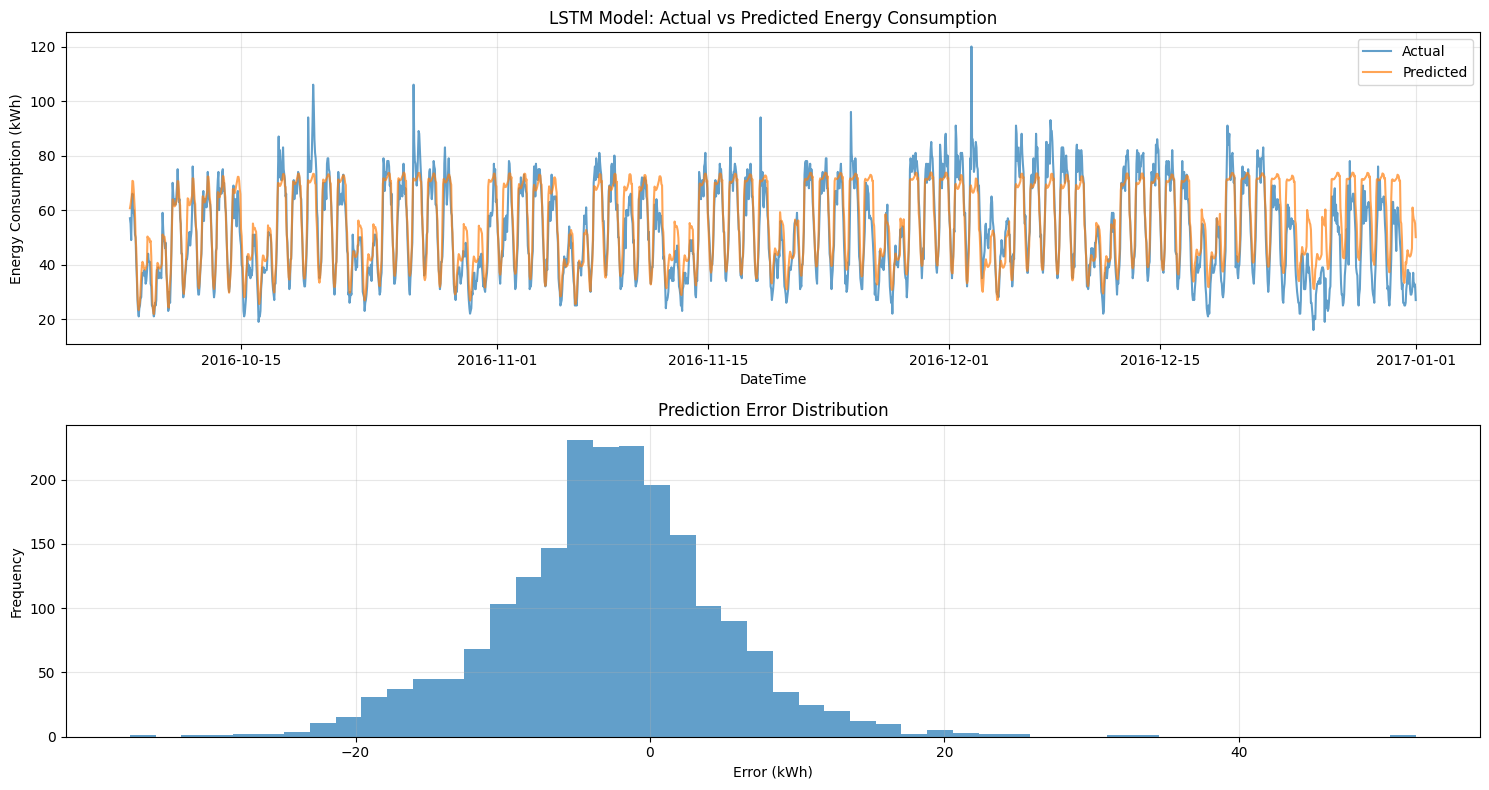

In [154]:

# Visualize results
plt.figure(figsize=(15, 8))

# Plot 1: Actual vs Predicted
plt.subplot(2,1,1)
plt.plot(val_df['DateTime'], y_val, label='Actual', alpha=0.7)
plt.plot(val_df['DateTime'], val_predictions, label='Predicted', alpha=0.7)
plt.title('LSTM Model: Actual vs Predicted Energy Consumption')
plt.xlabel('DateTime')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Error Distribution
plt.subplot(2,1,2)
errors = y_val - val_predictions.flatten()
plt.hist(errors, bins=50, alpha=0.7)
plt.title('Prediction Error Distribution')
plt.xlabel('Error (kWh)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [155]:

# Print metrics summary
print("\nModel Performance Metrics:")
print(f"RMSE: {rmse:.2f} kWh")
print(f"MAE: {mae:.2f} kWh") 
print(f"R² Score: {r2:.4f}")


Model Performance Metrics:
RMSE: 8.17 kWh
MAE: 6.17 kWh
R² Score: 0.7719


In [156]:
# 6. Process Test Data and Create Submission

# Load and validate test data
test_data = pd.read_csv('data/test_energy.csv')
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])

# Create features for test data using the same function as training
test_features = create_advanced_features(test_data)

# Process features
X_test = test_features[feature_columns]
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Generate predictions
test_predictions = model.predict(X_test_scaled, verbose=0)

# Create submission file with formatted predictions
submission = pd.DataFrame({
    'DateTime': test_data['DateTime'],
    'EnergyConsumption(kWh)': test_predictions.flatten().round(2)
})

# Save submission
submission.to_csv('lstm_submission.csv', index=False)

print(f"Created submission file with {len(submission)} predictions")
print(f"Prediction range: {submission['EnergyConsumption(kWh)'].min():.2f} - {submission['EnergyConsumption(kWh)'].max():.2f} kWh")

Created submission file with 4343 predictions
Prediction range: 21.96 - 72.97 kWh


### 3.2. Prophet

In [157]:
# Prepare data for Prophet
train_prophet = pd.DataFrame({
    'ds': train_df['DateTime'],
    'y': train_df['EnergyConsumption(kWh)']
})

val_prophet = pd.DataFrame({
    'ds': val_df['DateTime'],
    'y': val_df['EnergyConsumption(kWh)']
})

print(train_prophet.head())
print(val_prophet.head())

                   ds   y
0 2015-11-01 00:00:00  15
1 2015-11-01 01:00:00  13
2 2015-11-01 02:00:00  10
3 2015-11-01 03:00:00   7
4 2015-11-01 04:00:00   9
                      ds   y
8199 2016-10-07 15:00:00  57
8200 2016-10-07 16:00:00  55
8201 2016-10-07 17:00:00  49
8202 2016-10-07 18:00:00  61
8203 2016-10-07 19:00:00  66


In [158]:

# Create model with optimized parameters
model = Prophet(
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)

In [159]:
# Fit model
model.fit(train_prophet)

05:44:08 - cmdstanpy - INFO - Chain [1] start processing
05:44:10 - cmdstanpy - INFO - Chain [1] done processing


In [160]:
# Make predictions on validation set
forecast = model.predict(val_prophet[['ds']])

# Calculate metrics
rmse = np.sqrt(mean_squared_error(val_prophet['y'], forecast['yhat']))
mae = mean_absolute_error(val_prophet['y'], forecast['yhat'])
r2 = r2_score(val_prophet['y'], forecast['yhat'])

# Print metrics
print(f'Validation RMSE: {rmse:.2f}')
print(f'Validation MAE: {mae:.2f}')
print(f'Validation R2: {r2:.4f}')


Validation RMSE: 9.60
Validation MAE: 7.54
Validation R2: 0.6846


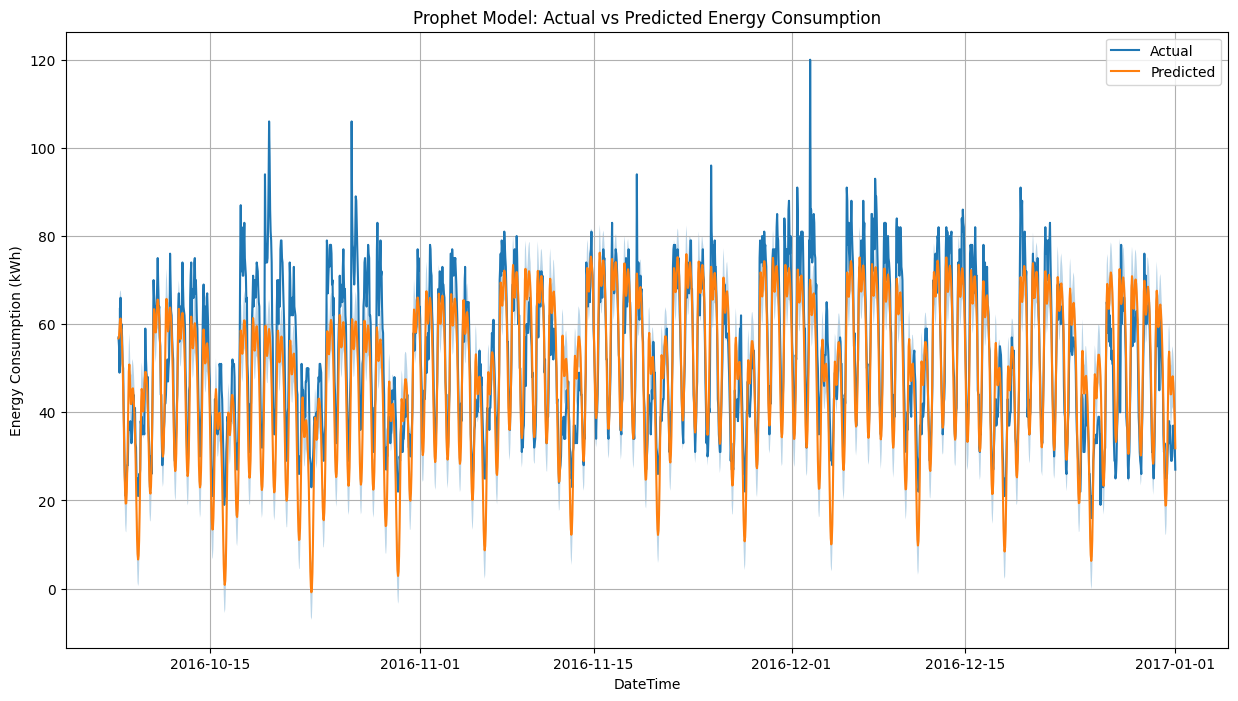

In [161]:

# Plot results
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(val_prophet['ds'], val_prophet['y'], label='Actual')
ax.plot(val_prophet['ds'], forecast['yhat'], label='Predicted')
ax.fill_between(val_prophet['ds'], 
                forecast['yhat_lower'], 
                forecast['yhat_upper'], 
                alpha=0.3)
ax.set_title('Prophet Model: Actual vs Predicted Energy Consumption')
ax.set_xlabel('DateTime')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
plt.grid(True)
plt.show()

In [137]:
# 1. Data Preparation
train_prophet = pd.DataFrame({
    'ds': train_data['DateTime'],
    'y': train_data['EnergyConsumption(kWh)']
})

test_data = pd.read_csv('data/test_energy.csv')
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])
test_prophet = pd.DataFrame({'ds': test_data['DateTime']})

print(train_prophet.tail())
print(test_prophet.head())


                       ds   y
10244 2016-12-31 20:00:00  37
10245 2016-12-31 21:00:00  32
10246 2016-12-31 22:00:00  33
10247 2016-12-31 23:00:00  32
10248 2017-01-01 00:00:00  27
                   ds
0 2017-01-01 01:00:00
1 2017-01-01 02:00:00
2 2017-01-01 03:00:00
3 2017-01-01 04:00:00
4 2017-01-01 05:00:00


In [138]:

# 2. Create and train Prophet model
model = Prophet(
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)

In [139]:

# 3. Fit model
model.fit(train_prophet)

# 4. Make predictions
forecast = model.predict(test_prophet)

# 5. Create submission
submission = pd.DataFrame({
    'DateTime': test_prophet['ds'],
    'EnergyConsumption(kWh)': forecast['yhat'].round(2)
})


05:32:55 - cmdstanpy - INFO - Chain [1] start processing
05:32:58 - cmdstanpy - INFO - Chain [1] done processing


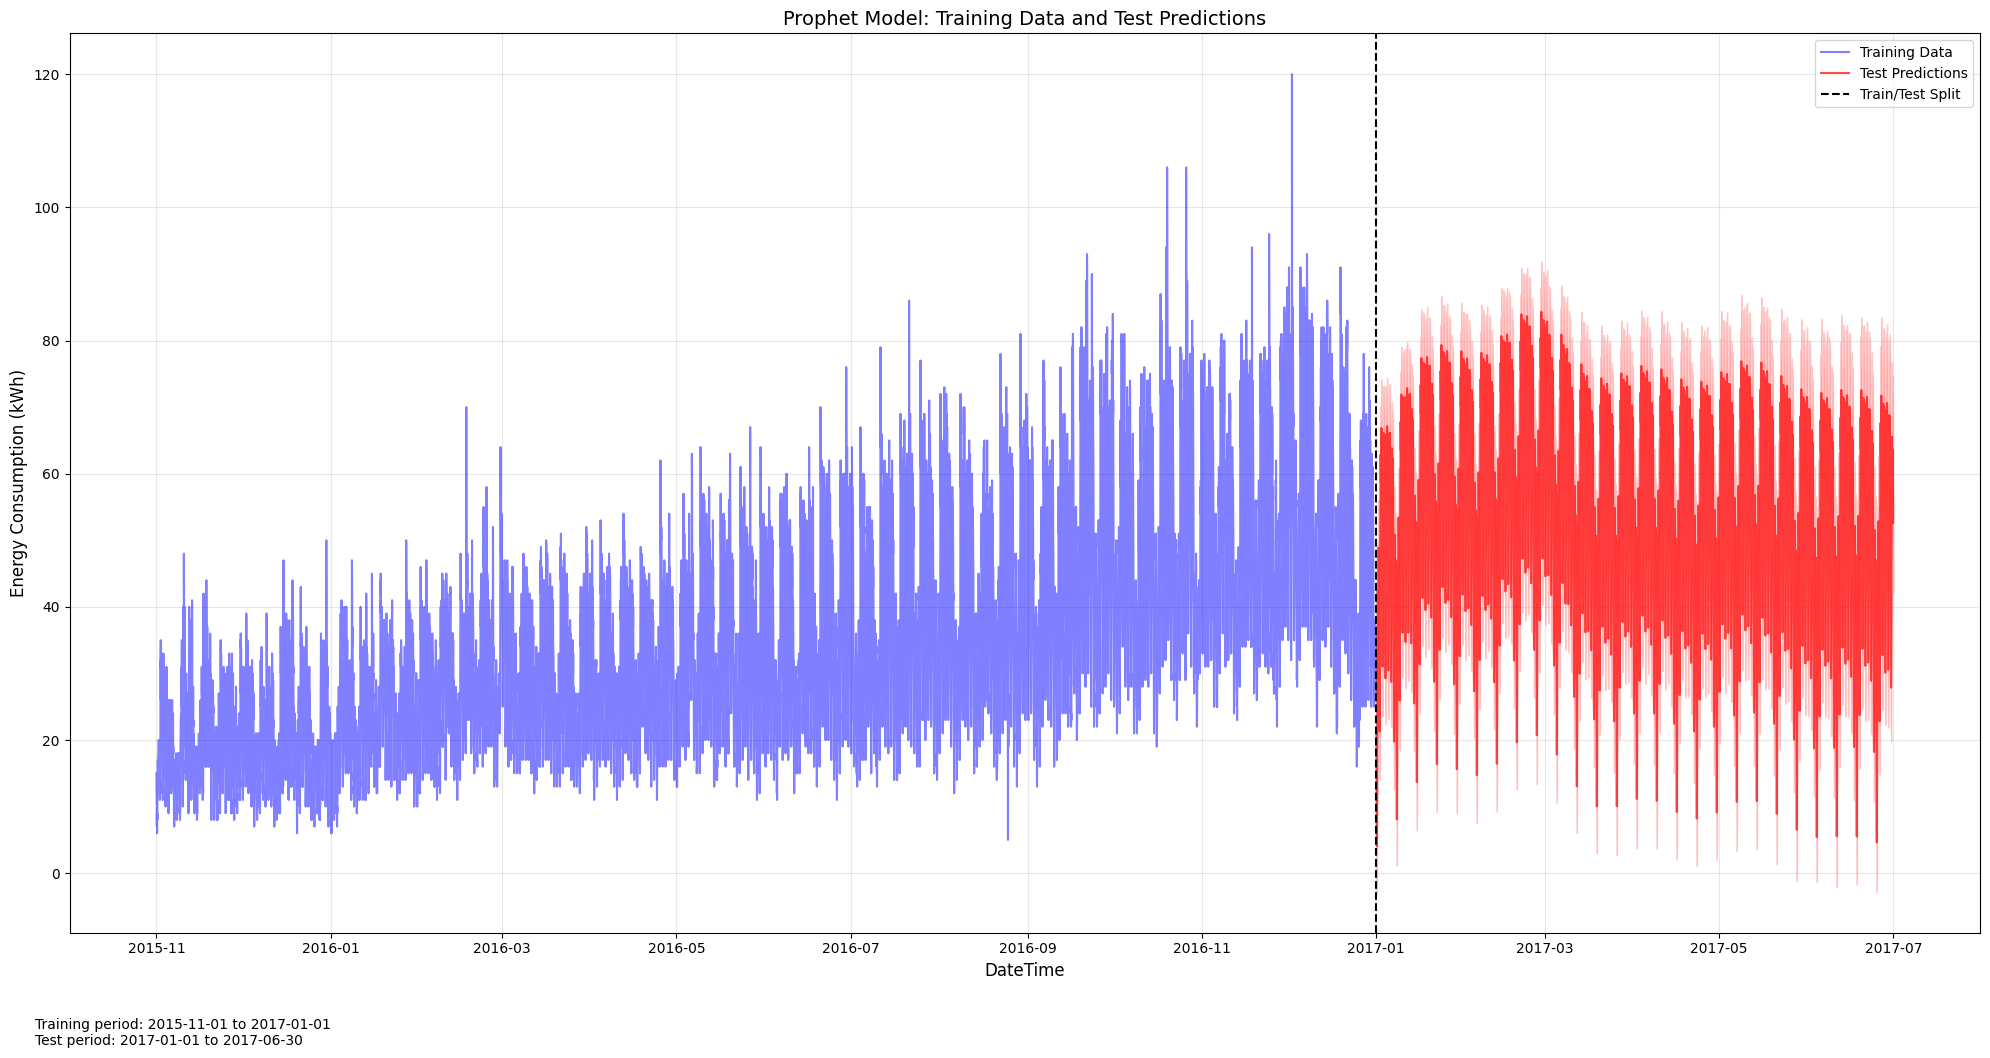

In [142]:
# Plot training data and test predictions
plt.figure(figsize=(20,10))

# Plot training data
plt.plot(train_prophet['ds'], train_prophet['y'], 
         label='Training Data', color='blue', alpha=0.5)

# Plot test predictions
plt.plot(forecast['ds'], forecast['yhat'], 
         label='Test Predictions', color='red', alpha=0.7)

# Add confidence intervals for predictions
plt.fill_between(forecast['ds'], 
                 forecast['yhat_lower'], 
                 forecast['yhat_upper'], 
                 color='red', alpha=0.2)

# Add vertical line to separate train and test
split_date = train_prophet['ds'].max()
plt.axvline(x=split_date, color='black', linestyle='--', label='Train/Test Split')

# Customize plot
plt.title('Prophet Model: Training Data and Test Predictions', fontsize=14)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Energy Consumption (kWh)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add date ranges
plt.figtext(0.02, -0.05, 
            f'Training period: {train_prophet["ds"].min().strftime("%Y-%m-%d")} to {train_prophet["ds"].max().strftime("%Y-%m-%d")}\n' +
            f'Test period: {forecast["ds"].min().strftime("%Y-%m-%d")} to {forecast["ds"].max().strftime("%Y-%m-%d")}',
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

In [141]:

# Save submission
submission.to_csv('prophet_submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!


### 3.3. N-BEATS (Neural Basis Expansion Analysis Time Series)

In [226]:
# 1. Improved Data Processing
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df[['EnergyConsumption(kWh)']])
val_scaled = scaler.transform(val_df[['EnergyConsumption(kWh)']])

# Longer sequence length for better pattern capture
def create_sequences(data, seq_length=48):  # Increased from 24
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

X_train, y_train = create_sequences(train_scaled)
X_val, y_val = create_sequences(val_scaled)

In [227]:
# 2. Enhanced Model Architecture
model = NBeatsNet(
    device='cpu',
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    forecast_length=1,
    backcast_length=SEQUENCE_LENGTH,
    hidden_layer_units=HIDDEN_UNITS,
    nb_blocks_per_stack=3,
    share_weights_in_stack=True,
    nb_harmonics=None
)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=48, forecast_length=1, share_thetas=False) at @132182266891376
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=48, forecast_length=1, share_thetas=False) at @132182266891376
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=48, forecast_length=1, share_thetas=False) at @132182266891376
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=8, backcast_length=48, forecast_length=1, share_thetas=False) at @132182452181968
     | -- GenericBlock(units=512, thetas_dim=8, backcast_length=48, forecast_length=1, share_thetas=False) at @132182452181968
     | -- GenericBlock(units=512, thetas_dim=8, backcast_length=48, forecast_length=1, share_thetas=False) at @132182452181968


In [228]:

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 3. Optimized Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # Reduced learning rate
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.2)  # Adjusted scheduler
criterion = torch.nn.MSELoss()
n_epochs = 500  # Increased epochs

# Create dataloaders with smaller batch size
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Reduced batch size

# Training loop with early stopping
best_loss = float('inf')
patience = 20
patience_counter = 0

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        forecast = model(batch_x)[0]  # Access the first element of the tuple
        loss = criterion(forecast, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Added gradient clipping
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    scheduler.step(avg_loss)
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), 'best_nbeats_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break
        
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Loss = {avg_loss:.6f}')

/home/adel_hb/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/adel_hb/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([23, 1])) that is different to the input size (torch.Size([23, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: Loss = 1.116201
Epoch 10: Loss = 0.114997
Epoch 20: Loss = 0.081769
Epoch 30: Loss = 0.066438
Epoch 40: Loss = 0.055923
Epoch 50: Loss = 0.047947
Epoch 60: Loss = 0.043418
Epoch 70: Loss = 0.042104
Epoch 80: Loss = 0.038233
Epoch 90: Loss = 0.044529
Epoch 100: Loss = 0.034586
Epoch 110: Loss = 0.034181
Epoch 120: Loss = 0.034025
Epoch 130: Loss = 0.033740
Epoch 140: Loss = 0.033606
Epoch 150: Loss = 0.033381
Epoch 160: Loss = 0.033164
Epoch 170: Loss = 0.033175
Epoch 180: Loss = 0.032979
Epoch 190: Loss = 0.032874
Epoch 200: Loss = 0.032724
Epoch 210: Loss = 0.032584
Epoch 220: Loss = 0.032431
Epoch 230: Loss = 0.032400
Epoch 240: Loss = 0.032388
Epoch 250: Loss = 0.032343
Epoch 260: Loss = 0.032331
Epoch 270: Loss = 0.032365
Epoch 280: Loss = 0.032338
Epoch 290: Loss = 0.032334
Epoch 300: Loss = 0.032312
Epoch 310: Loss = 0.032338
Early stopping at epoch 315


In [237]:
# 1. Data shape analysis
print("Original shapes:")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"Number of features: {X_val_scaled.shape[1]}")

# 2. Calculate correct dimensions
n_samples = (X_val_scaled.shape[0] - SEQUENCE_LENGTH + 1)
n_features = X_val_scaled.shape[1]

# 3. Create sliding windows
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:(i + seq_length)]
        sequences.append(sequence)
    return np.array(sequences)

# 4. Reshape data properly
X_val_reshaped = create_sequences(X_val_scaled, SEQUENCE_LENGTH)
print(f"\nReshaped dimensions:")
print(f"X_val_reshaped shape: {X_val_reshaped.shape}")
print(f"Expected shape: [samples, sequence_length, features]")

# 5. Verify reshape
assert X_val_reshaped.shape[1] == SEQUENCE_LENGTH, "Sequence length mismatch"
assert X_val_reshaped.shape[2] == n_features, "Feature count mismatch"

Original shapes:
X_val_scaled shape: (2050, 1, 18)
Number of features: 1

Reshaped dimensions:
X_val_reshaped shape: (2003, 48, 1, 18)
Expected shape: [samples, sequence_length, features]


val_df shape: (2050, 2)
actual_values shape: (2002,)
test_predictions shape: (48624, 1)


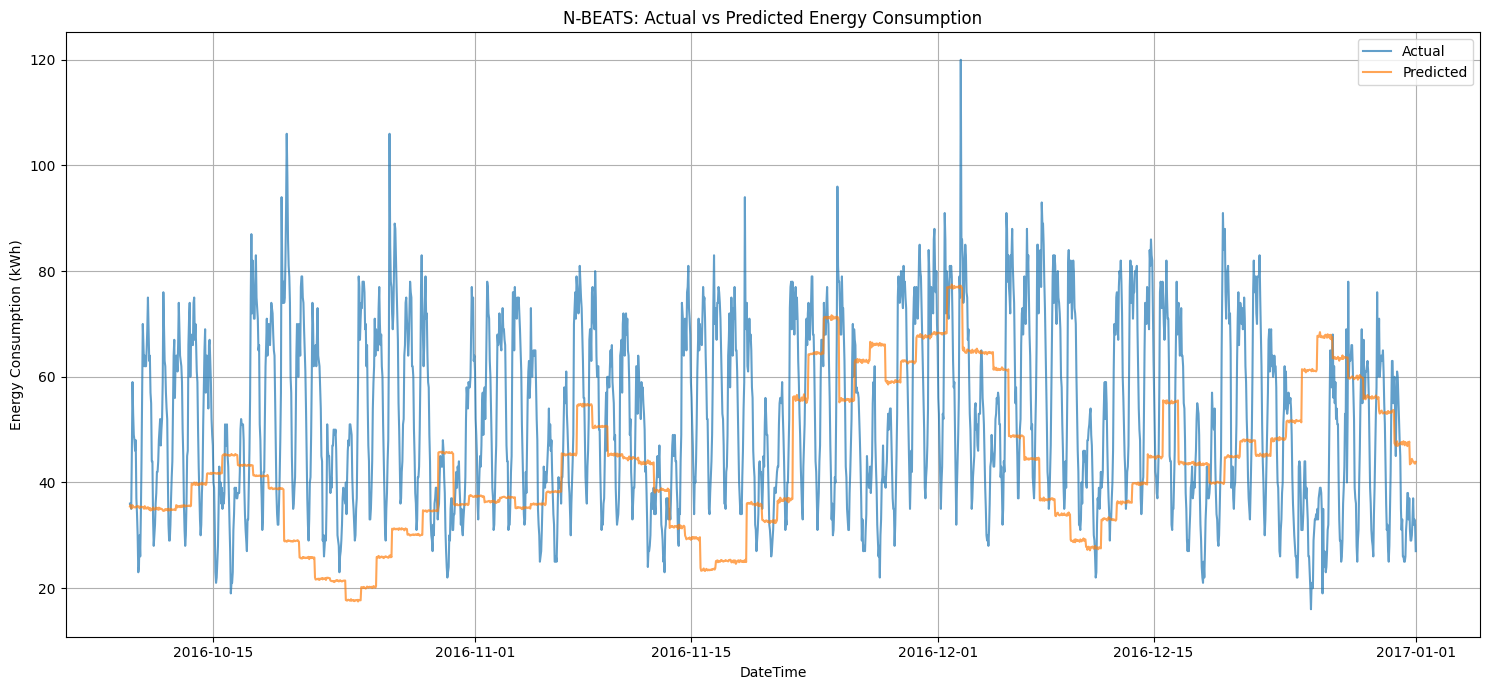

In [242]:
# 1. Data shape analysis
print(f"val_df shape: {val_df.shape}")

# 2. Create sequences and get actual values
val_scaled = scaler.transform(val_df[['EnergyConsumption(kWh)']])
X_val_reshaped = create_sequences(val_scaled, SEQUENCE_LENGTH)
actual_values = val_df['EnergyConsumption(kWh)'][SEQUENCE_LENGTH:].values

# 3. Plotting
plt.figure(figsize=(15, 7))

# Ensure aligned data
timestamp_range = val_df['DateTime'][SEQUENCE_LENGTH:SEQUENCE_LENGTH+len(actual_values)]
assert len(timestamp_range) == len(actual_values), "Length mismatch"

# Plot
plt.plot(timestamp_range, actual_values, label='Actual', alpha=0.7)
plt.plot(timestamp_range, test_predictions[:len(actual_values)], label='Predicted', alpha=0.7)
plt.title('N-BEATS: Actual vs Predicted Energy Consumption')
plt.xlabel('DateTime')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot and print shapes
print(f"actual_values shape: {actual_values.shape}")
print(f"test_predictions shape: {test_predictions.shape}")
plt.show()

In [241]:
# 3. Print RMSE for aligned data
rmse = np.sqrt(mean_squared_error(
    actual_values[:len(timestamp_range)], 
    test_predictions[:len(timestamp_range)]
))
print(f'Test RMSE: {rmse:.2f}')

Test RMSE: 23.48
